In [14]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd

In [15]:
import os
img_paths = []
for dirname, _, filenames in os.walk('/hdd/mduc/add-vgg/lib_ocr/training_images/images'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))

img_paths.sort()

In [16]:
df = pd.read_json('/hdd/mduc/add-vgg/lib_ocr/training_images/labels.json')
labels = df['labels'].to_list()

In [17]:
# df = pd.read_json('/kaggle/input/img-ocr-1000/output/labels.json')
labels = [label.lower() for label in labels]
letters = ''.join(labels)
letters = [char for char in letters]
letters = sorted(list(set(letters)))

chars = "".join(letters)
blank_char = "_"
chars += blank_char
vocab_size = len(chars) + 1 # Add 1 here is padding token

In [18]:
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [19]:
max_label_len = max([len(label) for label in labels])
max_label_len

18

In [20]:
def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths

In [21]:
def decode(encoded_sequences, idx_to_char, blank_char="_"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))
        
    # print(f"From {encoded_sequences} to {decoded_sequences}")

    return decoded_sequences

In [22]:
class Scaling:
    def __call__(self, image):
        w, h = image.size
        H = 100
        scale_ratio = H/h
        return transforms.functional.resize(image,(100, int(w*scale_ratio)))

In [23]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.Resize((100, 420)),
            Scaling(),
            # If the size is smaller than (100, 420), it will padding. Else it will crop. But above I have assertion if any image have size bigger than (100, 420)
            # transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            Scaling(),
            # transforms.CenterCrop((100, 420)),
            # transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [24]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

In [25]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

In [26]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

In [27]:
print(
    f"Train dataset: {len(train_dataset)}",
    f"Val dataset: {len(val_dataset)}",
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 810
Val dataset: 100
Test dataset: 90


In [28]:
train_batch_size = 64
test_batch_size = 64 * 4

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

In [29]:
vocab_size

68

In [30]:
train_features, train_labels, train_lengths = next(iter(train_loader))


# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()


show_batch(train_features, train_labels)

RuntimeError: stack expects each tensor to be equal size, but got [3, 100, 193] at entry 0 and [3, 100, 656] at entry 1

In [37]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [38]:
hidden_size = 256
n_layers = 3
dropout_prob = 0
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device) 

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [39]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([14, 64, 68])


In [40]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            # Print some samples after decoding
            # if idx == 0:
            #     print(decode(outputs.permute(1, 0, 2).argmax(2), idx_to_char)[:10])
            #     print(decode(labels, idx_to_char)[:10])

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [41]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())

            loss.backward()

            # Gradient clipping with a configurable max norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

In [42]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.2

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.5
)

In [43]:
torch.autograd.set_detect_anomaly(True)
train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

EPOCH 1:	Train loss: 5.1411	Val loss: 4.0048		 Time: 9.67 seconds
EPOCH 2:	Train loss: 3.6015	Val loss: 3.6677		 Time: 5.39 seconds
EPOCH 3:	Train loss: 3.3327	Val loss: 3.4321		 Time: 5.44 seconds
EPOCH 4:	Train loss: 2.8397	Val loss: 3.4698		 Time: 5.37 seconds
EPOCH 5:	Train loss: 2.2153	Val loss: 2.3802		 Time: 5.38 seconds
EPOCH 6:	Train loss: 1.6290	Val loss: 1.9056		 Time: 5.24 seconds
EPOCH 7:	Train loss: 1.2222	Val loss: 1.3672		 Time: 5.37 seconds
EPOCH 8:	Train loss: 0.7831	Val loss: 1.0469		 Time: 5.30 seconds
EPOCH 9:	Train loss: 0.4860	Val loss: 0.7828		 Time: 5.27 seconds
EPOCH 10:	Train loss: 0.3507	Val loss: 0.7011		 Time: 5.30 seconds
EPOCH 11:	Train loss: 0.2348	Val loss: 0.5925		 Time: 5.24 seconds
EPOCH 12:	Train loss: 0.1684	Val loss: 0.6387		 Time: 5.31 seconds
EPOCH 13:	Train loss: 0.1074	Val loss: 0.5887		 Time: 5.41 seconds
EPOCH 14:	Train loss: 0.0880	Val loss: 0.4856		 Time: 5.40 seconds
EPOCH 15:	Train loss: 0.0607	Val loss: 0.5470		 Time: 5.47 seconds
EPOC

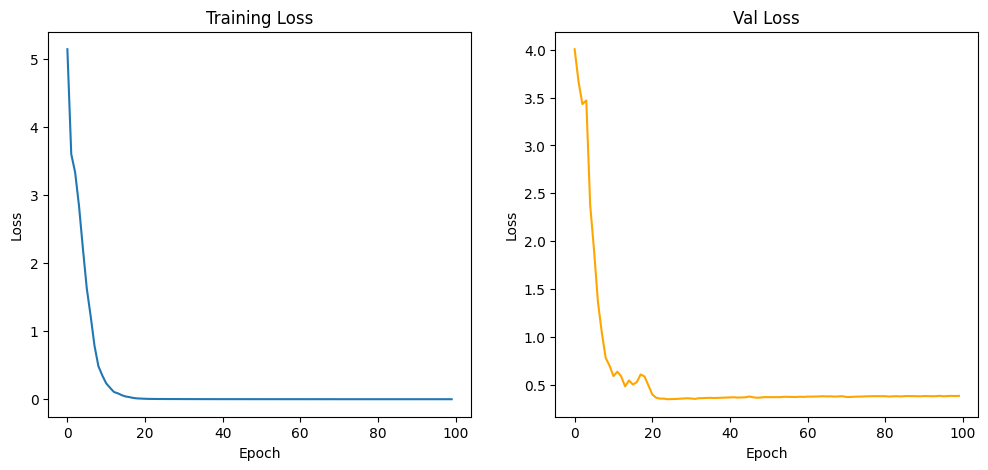

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

In [45]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  0.38644278049468994
Test loss:  0.3610713481903076


In [46]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)
        
def decode_label(encoded_sequences, idx_to_char, blank_char="_"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

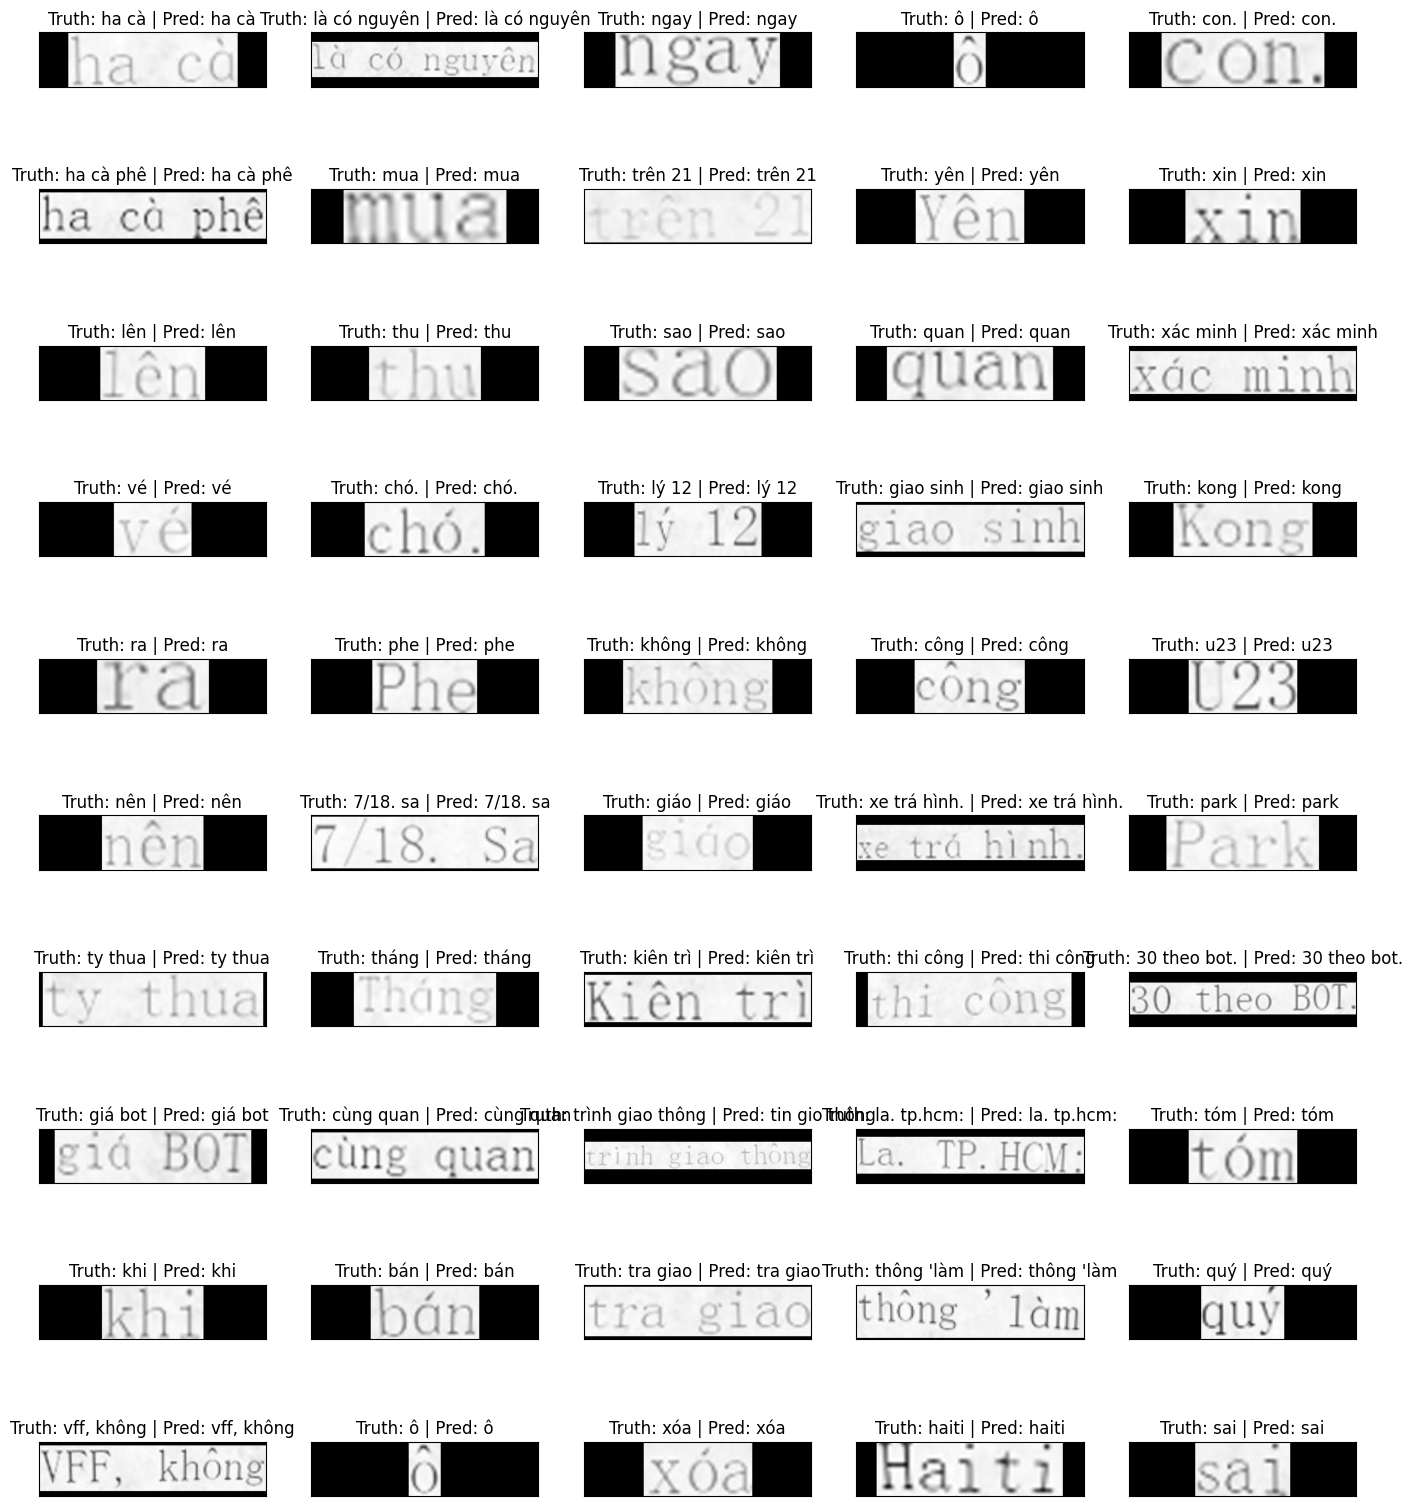

In [47]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(train_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

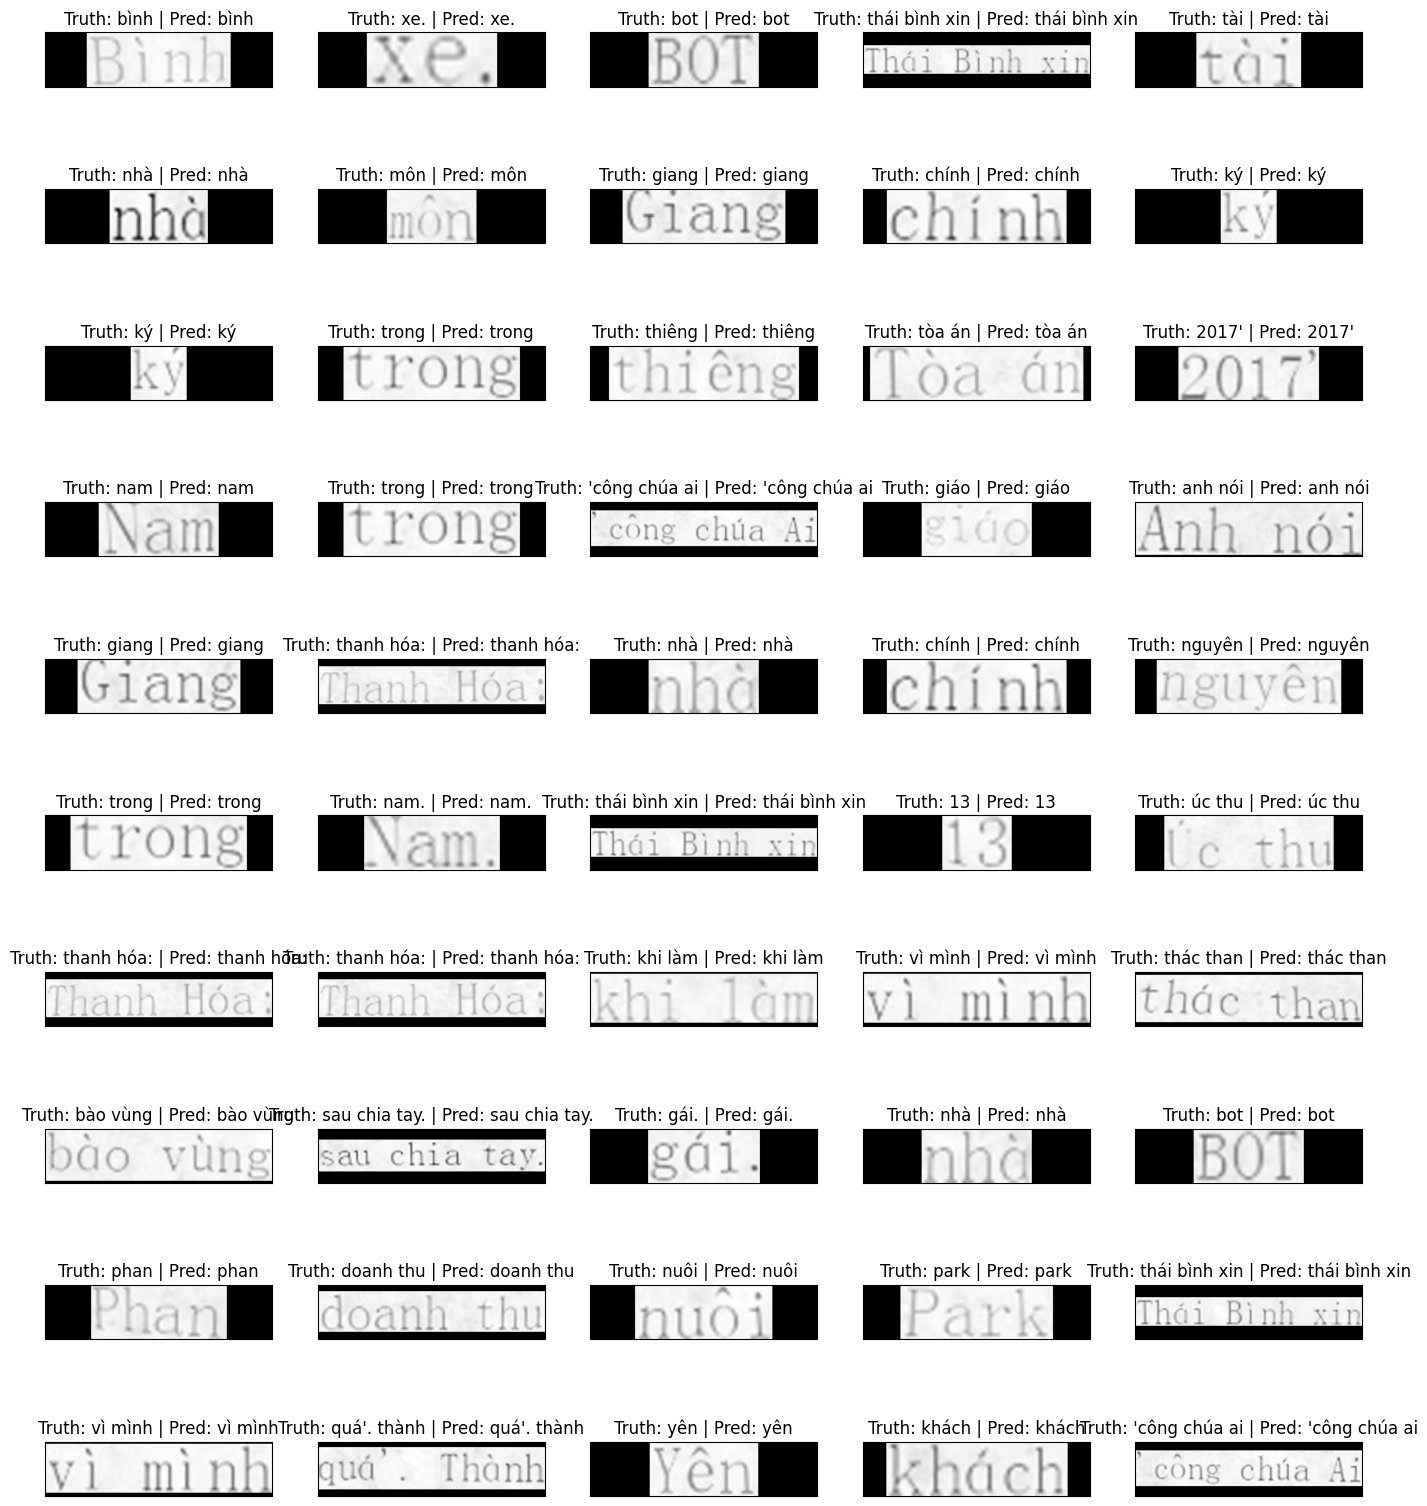

In [48]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

In [49]:
    save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)